In [1]:
from glob import glob
from tqdm import tqdm_notebook as tqdm

import numpy as np
import pandas as pd

import torch

from matplotlib import pyplot as plt
import seaborn as sns

from transformers import BertTokenizer, BertModel

pd.set_option("display.max_rows", 300)

## e069 の valid を確認する

In [2]:
trn_df = pd.read_csv('../inputs/origin/train.csv')
display(trn_df.shape, trn_df.head())

(27481, 4)

,textID,text,selected_text,sentiment
0,cb774db0d1,"I`d have responded, if I were going","I`d have responded, if I were going",neutral
1,549e992a42,Sooo SAD I will miss you here in San Diego!!!,Sooo SAD,negative
2,088c60f138,my boss is bullying me...,bullying me,negative
3,9642c003ef,what interview! leave me alone,leave me alone,negative
4,358bd9e861,"Sons of ****, why couldn`t they put them on t...","Sons of ****,",negative


In [3]:
trn_df = trn_df[trn_df.selected_text.notnull()]
trn_df.shape

(27480, 4)

In [4]:
ckpts = []
for fckpt in glob('../checkpoints/e069/best/*'):
    ckpts.append(torch.load(fckpt))

In [15]:
ckpts[0].keys()

dict_keys(['fold_num', 'current_epoch', 'model_state_dict', 'optimizer_state_dict', 'scheduler_state_dict', 'val_textIDs', 'val_input_ids', 'val_preds', 'val_labels', 'histories'])

In [6]:
def _get_predicted_texts(input_ids, y_preds_head, y_preds_tail, tokenizer):
    predicted_texts = []
    for input_id, y_pred_head, y_pred_tail \
            in zip(input_ids, y_preds_head, y_preds_tail):
        pred_label_head = y_pred_head.argmax()
        pred_label_tail = y_pred_tail.argmax()
        predicted_text = tokenizer.decode(
            input_id[pred_label_head:pred_label_tail])
        predicted_texts.append(predicted_text)

    return predicted_texts

In [7]:
def _get_selected_texts(input_ids, labels_head, labels_tail, tokenizer):
    predicted_texts = []
    for input_id, pred_label_head, pred_label_tail \
            in zip(input_ids, labels_head, labels_tail):
        predicted_text = tokenizer.decode(
            input_id[pred_label_head:pred_label_tail])
        predicted_texts.append(predicted_text)

    return predicted_texts

In [8]:
import sys
sys.path.append('../')
from tools.tokenizers import myRobertaByteLevelBPETokenizer

tokenizer = myRobertaByteLevelBPETokenizer(   
    vocab_file='../inputs/datasets/roberta/tokenizer/vocab.json',
    merges_file='../inputs/datasets/roberta/tokenizer/merges.txt',
    lowercase=True,
    add_prefix_space=True)

# tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

In [9]:
for ckpt in ckpts:
    trn_df = trn_df.set_index('textID')
    predicted_texts = _get_predicted_texts(ckpt['val_input_ids'], ckpt['val_preds'][0],  ckpt['val_preds'][1], tokenizer)
    trn_df.loc[ckpt['val_textIDs'], 'predicted_texts'] = predicted_texts
    trn_df = trn_df.reset_index()
trn_df

,textID,text,selected_text,sentiment,predicted_texts
0,cb774db0d1,"I`d have responded, if I were going","I`d have responded, if I were going",neutral,"i`d have responded, if i were going"
1,549e992a42,Sooo SAD I will miss you here in San Diego!!!,Sooo SAD,negative,sooo sad
2,088c60f138,my boss is bullying me...,bullying me,negative,bullying me...
3,9642c003ef,what interview! leave me alone,leave me alone,negative,leave me alone
4,358bd9e861,"Sons of ****, why couldn`t they put them on t...","Sons of ****,",negative,"****,"
...,...,...,...,...,...
27475,4eac33d1c0,wish we could come see u on Denver husband l...,d lost,negative,lost his job and can`t afford it
27476,4f4c4fc327,I`ve wondered about rake to. The client has ...,", don`t force",negative,
27477,f67aae2310,Yay good for both of you. Enjoy the break - y...,Yay good for both of you.,positive,yay good
27478,ed167662a5,But it was worth it ****.,But it was worth it ****.,positive,worth


In [10]:
for ckpt in ckpts:
    trn_df = trn_df.set_index('textID')
    manual_selected_texts = _get_selected_texts(ckpt['val_input_ids'], ckpt['val_labels'][0],  ckpt['val_labels'][1], tokenizer)
    trn_df.loc[ckpt['val_textIDs'], 'manual_selected_text'] = manual_selected_texts
    trn_df = trn_df.reset_index()
trn_df

,textID,text,selected_text,sentiment,predicted_texts,manual_selected_text
0,cb774db0d1,"I`d have responded, if I were going","I`d have responded, if I were going",neutral,"i`d have responded, if i were going","i`d have responded, if i were going"
1,549e992a42,Sooo SAD I will miss you here in San Diego!!!,Sooo SAD,negative,sooo sad,sooo sad
2,088c60f138,my boss is bullying me...,bullying me,negative,bullying me...,bullying me
3,9642c003ef,what interview! leave me alone,leave me alone,negative,leave me alone,leave me alone
4,358bd9e861,"Sons of ****, why couldn`t they put them on t...","Sons of ****,",negative,"****,","sons of ****,"
...,...,...,...,...,...,...
27475,4eac33d1c0,wish we could come see u on Denver husband l...,d lost,negative,lost his job and can`t afford it,husband lost
27476,4f4c4fc327,I`ve wondered about rake to. The client has ...,", don`t force",negative,,", don`t force"
27477,f67aae2310,Yay good for both of you. Enjoy the break - y...,Yay good for both of you.,positive,yay good,yay good for both of you.
27478,ed167662a5,But it was worth it ****.,But it was worth it ****.,positive,worth,but it was worth it ****.


In [11]:
trn_df.query('textID == "6cd1ba8680"')

,textID,text,selected_text,sentiment,predicted_texts,manual_selected_text
19561,6cd1ba8680,Thats charmingly funny,ats charmingly fun,positive,thats charmingly funny,thats charmingly funny


In [12]:
trn_df[trn_df.manual_selected_text.str.contains('</s>')]

,textID,text,selected_text,sentiment,predicted_texts,manual_selected_text


In [13]:
trn_df['selected_text_lower'] = trn_df['selected_text'].apply(lambda x: " " + " ".join(x.lower().split()))
trn_df

,textID,text,selected_text,sentiment,predicted_texts,manual_selected_text,selected_text_lower
0,cb774db0d1,"I`d have responded, if I were going","I`d have responded, if I were going",neutral,"i`d have responded, if i were going","i`d have responded, if i were going","i`d have responded, if i were going"
1,549e992a42,Sooo SAD I will miss you here in San Diego!!!,Sooo SAD,negative,sooo sad,sooo sad,sooo sad
2,088c60f138,my boss is bullying me...,bullying me,negative,bullying me...,bullying me,bullying me
3,9642c003ef,what interview! leave me alone,leave me alone,negative,leave me alone,leave me alone,leave me alone
4,358bd9e861,"Sons of ****, why couldn`t they put them on t...","Sons of ****,",negative,"****,","sons of ****,","sons of ****,"
...,...,...,...,...,...,...,...
27475,4eac33d1c0,wish we could come see u on Denver husband l...,d lost,negative,lost his job and can`t afford it,husband lost,d lost
27476,4f4c4fc327,I`ve wondered about rake to. The client has ...,", don`t force",negative,,", don`t force",", don`t force"
27477,f67aae2310,Yay good for both of you. Enjoy the break - y...,Yay good for both of you.,positive,yay good,yay good for both of you.,yay good for both of you.
27478,ed167662a5,But it was worth it ****.,But it was worth it ****.,positive,worth,but it was worth it ****.,but it was worth it ****.


In [14]:
(trn_df.selected_text_lower == trn_df.manual_selected_text).mean()

0.9046943231441048

In [16]:
(trn_df.selected_text_lower == trn_df.manual_selected_text).mean()

0.9046943231441048

In [17]:
trn_df[(trn_df.selected_text_lower != trn_df.manual_selected_text)].query('sentiment != "neutral"').head(100)

,textID,text,selected_text,sentiment,predicted_texts,manual_selected_text,selected_text_lower
18,af3fed7fc3,is back home now gonna miss every one,onna,negative,miss,gonna,onna
27,bdc32ea43c,On the way to Malaysia...no internet access to...,.no internet,negative,no internet access to twit,...no internet,.no internet
32,1c31703aef,If it is any consolation I got my BMI tested ...,well so much for being unhappy for about 10 mi...,negative,unhappy,well so much for being unhappy for about 10 m...,well so much for being unhappy for about 10 m...
39,2863f435bd,A little happy for the wine jeje ok it`sm my f...,A little happy fo,positive,love this day,a little happy for,a little happy fo
48,3d9d4b0b55,"i donbt like to peel prawns, i also dont like ...",dont like go,negative,"i donbt like to peel prawns, i also dont like",dont like going,dont like go
49,3fcea4debc,which case? I got a new one last week and I`m...,d I`m not thrilled at all with mine.,negative,not thrilled at all with mine.,and i`m not thrilled at all with mine.,d i`m not thrilled at all with mine.
64,98f25bc596,mannnn..... _ got an iphone!!! im jealous.... ...,jealous..,negative,im jealous....,jealous....,jealous..
66,95e12b1cb1,He`s awesome... Have you worked with him bef...,s awesome,positive,he`s awesome...,s awesome,s awesome
84,4cd390c007,Still no reply from about my SimFinger proble...,", sorry guys",negative,sorry guys,", sorry guys",", sorry guys"
102,ebcdf07ac5,"1 week post my'horrible, traumatic jumping cho...","horrible,",negative,"horrible, traumatic","horrible,","horrible,"


In [18]:
trn_df.shape, trn_df[(trn_df.selected_text_lower != trn_df.manual_selected_text)].shape

((27480, 7), (2619, 7))

In [19]:
trn_df['manual_and_selected_intersection_len'] = trn_df.apply(lambda row: len(set(row['manual_selected_text'].split()) & set(row['selected_text_lower'].split())), axis=1)
trn_df['manual_and_selected_intersection_len'].value_counts().sort_index()

0      334
1     7211
2     2313
3     2163
4     1983
5     1603
6     1380
7     1176
8     1012
9      879
10     812
11     732
12     669
13     578
14     558
15     504
16     470
17     454
18     435
19     395
20     414
21     335
22     317
23     289
24     211
25     114
26      77
27      40
28      14
29       8
Name: manual_and_selected_intersection_len, dtype: int64

In [20]:
trn_df['manual_and_selected_tokenized_intersection_len'] = trn_df.apply(lambda row: len(set(tokenizer.encode(' '.join(row['manual_selected_text'].split()), add_special_tokens=False).ids) & set(tokenizer.encode(' '.join(row['selected_text_lower'].split()), add_special_tokens=False).ids)), axis=1)
trn_df['manual_and_selected_tokenized_intersection_len'].value_counts().sort_index()

0       66
1     5172
2     2825
3     1859
4     1746
5     1628
6     1335
7     1152
8     1027
9      961
10     800
11     701
12     684
13     649
14     584
15     502
16     514
17     477
18     445
19     452
20     380
21     361
22     375
23     354
24     368
25     317
26     307
27     278
28     243
29     238
30     165
31     128
32     134
33      88
34      56
35      29
36      25
37      16
38      15
39       8
40       8
41       5
42       3
Name: manual_and_selected_tokenized_intersection_len, dtype: int64

In [21]:
trn_df.query('manual_and_selected_tokenized_intersection_len == 0').head(100)

,textID,text,selected_text,sentiment,predicted_texts,manual_selected_text,selected_text_lower,manual_and_selected_intersection_len,manual_and_selected_tokenized_intersection_len
18,af3fed7fc3,is back home now gonna miss every one,onna,negative,miss,gonna,onna,0,0
309,a54d3c2825,"I know It was worth a shot, though!",as wort,positive,worth,was worth,as wort,0,0
491,ee9df322d1,"Sorry, we`ll try to keep it down.",Sorr,negative,"sorry,",sorry,sorr,0,0
808,31fa81e0ae,"Yes, you should go see Star Trek! It`s sooo...",ch fu,positive,it`s sooooo much fun!,much fun,ch fu,0,0
1727,795de6c2f5,ooh ouch! lovely weather but ****! cover up...,lovel,positive,lovely,lovely,lovel,0,0
1797,c4ffb519a5,I don`t feel any pressure right now... Happ...,Happ,positive,happy mother`s day people...,happy,happ,0,0
2597,95593ecedb,"Cool Sound!! Luv 'Drama', 'Love Game' doesn`t...",ish Go,positive,cool,wish good,ish go,0,0
2786,acfbac049f,Sure! My entire blogroll is terribly updat...,uld motiva,positive,motivate,could motivate,uld motiva,0,0
3324,ee5eb5337b,Heading to the gym. The group of guys that US...,ly sa,negative,makes me terribly sad,terribly sad,ly sa,0,0
3503,d5b33ff5f4,it was just true and you do cause me to hav...,ng dirt,negative,dirty thoughts,having dirty,ng dirt,0,0


In [22]:
trn_df.to_csv('../inputs/nes_info/e069_dataset_trn_df.csv', index=False)

## error analysis

In [26]:
from tools.metrics import jaccard

In [28]:
trn_df['jaccard'] = trn_df.apply(lambda row: jaccard(row['predicted_texts'], row['selected_text_lower']), axis=1)

In [30]:
trn_df[(trn_df.manual_and_selected_tokenized_intersection_len > 0)].sort_values('jaccard').head(100)

,textID,text,selected_text,sentiment,predicted_texts,manual_selected_text,selected_text_lower,manual_and_selected_intersection_len,manual_and_selected_tokenized_intersection_len,jaccard
3373,323e53905b,i bet they will be great bags! Can`t wait!,! Can`t wait!,positive,great,! can`t wait!,! can`t wait!,3,6,0.0
4553,8154e7fb2f,_crazyangel Gah But Gregg should have got th...,", dammit",negative,dammit!,", dammit",", dammit",2,3,0.0
20089,c6b6e97053,This is great curl-up-in-a-ball-and-read later...,I wish I had a book.,positive,great,i wish i had a book.,i wish i had a book.,5,6,0.0
7676,e6da2d1835,New issue of in the office...desperately want...,New issue of in the office...desperately want...,negative,desperately,new issue of in the office...desperately want...,new issue of in the office...desperately want...,17,24,0.0
13114,3dc5d762fe,Britain`s got (good) Weather. I wish I had som...,Britain`s got (good) Weather. I wish I had som...,positive,good),britain`s got (good) weather. i wish i had so...,britain`s got (good) weather. i wish i had so...,12,19,0.0
20093,49d309d88a,is hanging out with the roomies. I adore the 4...,Great,positive,adore,great,great,1,1,0.0
15984,9cd96e7c95,the downfall about relaxing later is mad manua...,house work blues,negative,downfall,house work blues,house work blues,3,3,0.0
1488,54acae24bc,No one wants to sit with me at lunch I guess ...,No one wants to sit with me,negative,anti-social.,no one wants to sit with me,no one wants to sit with me,7,7,0.0
15980,239a6def97,will u give ur mother anything special? I`ll ...,stressfree,positive,"cheesy, but it works",stressfree,stressfree,1,2,0.0
20097,c213900189,Another nice day again! Working in Goderich to...,enjoy,positive,another nice day again!,enjoy,enjoy,1,1,0.0


In [33]:
trn_df[(trn_df.manual_and_selected_tokenized_intersection_len > 0) & (trn_df.jaccard > 0)].sort_values('jaccard').head(100)

,textID,text,selected_text,sentiment,predicted_texts,manual_selected_text,selected_text_lower,manual_and_selected_intersection_len,manual_and_selected_tokenized_intersection_len,jaccard
26309,1d10473fc1,"..Get Over On His Mom & Now I Feel Horrible, H...","..Get Over On His Mom & Now I Feel Horrible, H...",negative,"horrible,","..get over on his mom & now i feel horrible, ...","..get over on his mom & now i feel horrible, ...",26,32,0.038462
26017,b94c7eeaf4,Comp. Mental Health wouldn`t take me. Samuel R...,worth,positive,comp. mental health wouldn`t take me. samuel ...,worth,worth,1,1,0.038462
5965,699bb2c9c9,"so, why the hell are we going to school for 2 ...","so, why the hell are we going to school for 2 ...",negative,lame rules...,"so, why the hell are we going to school for 2...","so, why the hell are we going to school for 2...",25,33,0.038462
27347,ea7bc30d23,Killed a pigeon today Thought it was going to...,Killed a pigeon today Thought it was going to...,negative,killed,killed a pigeon today thought it was going to...,killed a pigeon today thought it was going to...,26,28,0.038462
13698,23e8533b42,It`s so awesome to know that there are people ...,It`s so awesome to know that there are people ...,positive,awesome,it`s so awesome to know that there are people...,it`s so awesome to know that there are people...,25,29,0.040000
10323,78099bff95,"And, I`m accumulating money again, so I can us...",saving,positive,"and, i`m accumulating money again, so i can u...",saving,saving,1,1,0.040000
26664,0cee22656f,Is it sad that I`m a little sad it was the las...,hard.,negative,is it sad that i`m a little sad it was the la...,hard.,hard.,1,2,0.040000
17633,0c321384c6,OCHH ive got blister on my foot over the sun t...,OCHH ive got blister on my foot over the sun t...,negative,sore,ochh ive got blister on my foot over the sun ...,ochh ive got blister on my foot over the sun ...,25,33,0.040000
4573,9feac012d5,Looks like the #GM Bankruptcy is going to happ...,Looks like the #GM Bankruptcy is going to happ...,negative,loss,looks like the #gm bankruptcy is going to hap...,looks like the #gm bankruptcy is going to hap...,25,27,0.040000
18707,6bebb81892,is going to relax and chill out tonight ... ba...,is going to relax and chill out tonight ... ba...,positive,fun,is going to relax and chill out tonight ... b...,is going to relax and chill out tonight ... b...,24,24,0.041667


/opt/conda/lib/python3.7/site-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 20998 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/opt/conda/lib/python3.7/site-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 24067 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/opt/conda/lib/python3.7/site-packages/matplotlib/backends/backend_agg.py:183: RuntimeWarning: Glyph 20998 missing from current font.
  font.set_text(s, 0, flags=flags)
/opt/conda/lib/python3.7/site-packages/matplotlib/backends/backend_agg.py:183: RuntimeWarning: Glyph 24067 missing from current font.
  font.set_text(s, 0, flags=flags)


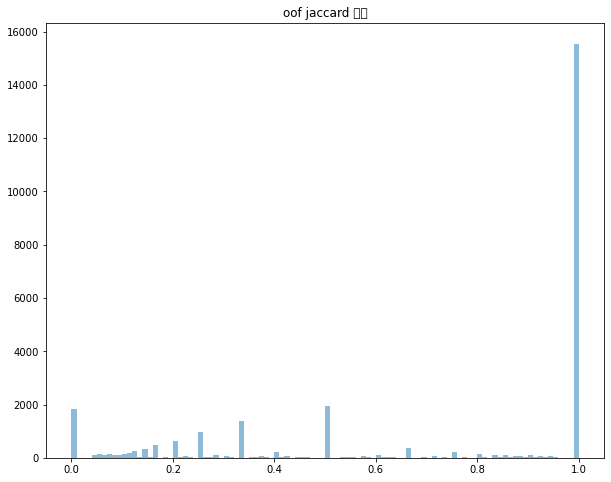

In [40]:
plt.figure(figsize = (10, 8))
plt.hist(trn_df.jaccard, bins=np.arange(0, 1.01, 0.01), alpha=0.5)
plt.title('oof jaccard 分布')
plt.show()

In [43]:
trn_df.query('jaccard == 0.5').head(100)

,textID,text,selected_text,sentiment,predicted_texts,manual_selected_text,selected_text_lower,manual_and_selected_intersection_len,manual_and_selected_tokenized_intersection_len,jaccard
12,74a76f6e0a,My Sharpie is running DANGERously low on ink,DANGERously,negative,dangerously low,dangerously,dangerously,1,1,0.5
29,d22e6d40a7,Went to sleep and there is a power cut in Noid...,Power back up not working too,negative,not working too,power back up not working too,power back up not working too,6,6,0.5
30,d33f811375,I`m going home now. Have you seen my new twitt...,Quite....heavenly,positive,quite....heavenly isn`****?,quite....heavenly,quite....heavenly,1,5,0.5
31,7d8c4c11e4,i hope unni will make the audition . fighting ...,hope,positive,i hope,hope,hope,1,1,0.5
80,bbbc46889b,THANK YYYYYYYYYOOOOOOOOOOUUUUU!,THANK YYYYYYYYYOOOOOOOOOOUUUUU!,positive,thank,thank yyyyyyyyyoooooooooouuuuu!,thank yyyyyyyyyoooooooooouuuuu!,2,8,0.5
81,58d382e07a,lucky kid...i so wanna see loserville pity i...,lucky,positive,lucky kid...,lucky,lucky,1,1,0.5
88,bffa3ddd61,i miss you bby wish you were going tomorr...,i miss you bby,negative,i miss,i miss you bby,i miss you bby,4,5,0.5
102,ebcdf07ac5,"1 week post my'horrible, traumatic jumping cho...","horrible,",negative,"horrible, traumatic","horrible,","horrible,",1,2,0.5
122,66057d58c2,"Not looking forward to next week: Maths, Geogr...",Not looking forward,negative,not looking forward to next week:,not looking forward,not looking forward,3,3,0.5
123,af90ad5989,Poor you Get outside and sleep in the garden...,Poor you,negative,poor,poor you,poor you,2,2,0.5


In [61]:
trn_df['text_len'] = trn_df['text'].str.len()
trn_df['selected_text_len'] = trn_df['selected_text'].str.len()
trn_df['predicted_texts_len'] = trn_df['predicted_texts'].str.len()

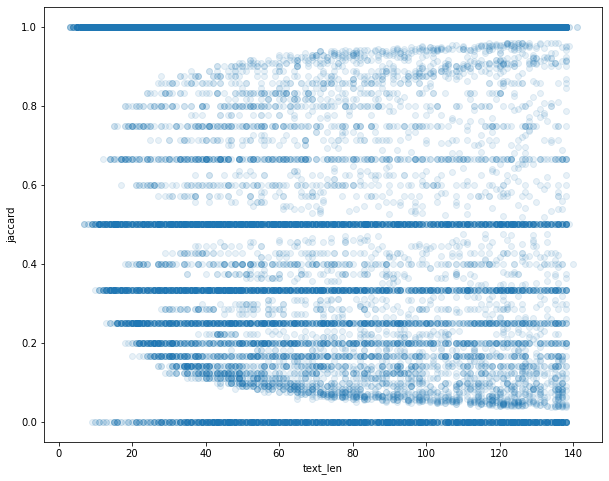

In [53]:
plt.figure(figsize=(10, 8))
plt.scatter(trn_df['text_len'], trn_df['jaccard'], alpha=0.1)
plt.xlabel('text_len')
plt.ylabel('jaccard')
plt.show()

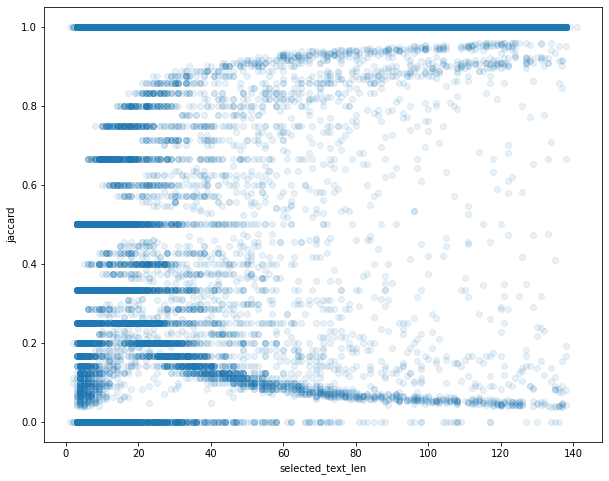

In [54]:
plt.figure(figsize=(10, 8))
plt.scatter(trn_df['selected_text_len'], trn_df['jaccard'], alpha=0.1)
plt.xlabel('selected_text_len')
plt.ylabel('jaccard')
plt.show()

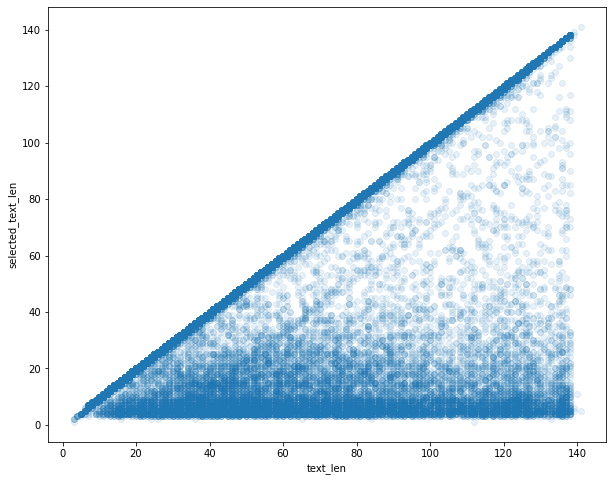

In [57]:
plt.figure(figsize=(10, 8))
plt.scatter(trn_df['text_len'], trn_df['selected_text_len'], alpha=0.1)
plt.xlabel('text_len')
plt.ylabel('selected_text_len')
plt.show()

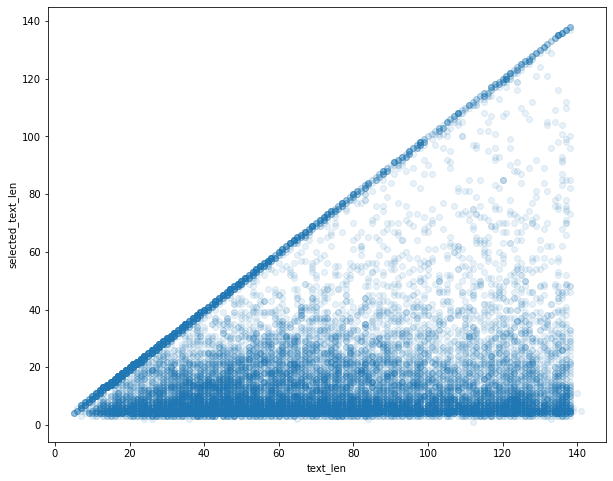

In [81]:
plt.figure(figsize=(10, 8))
plt.scatter(trn_df.query('sentiment != "neutral"')['text_len'], trn_df.query('sentiment != "neutral"')['selected_text_len'], alpha=0.1)
plt.xlabel('text_len')
plt.ylabel('selected_text_len')
plt.show()

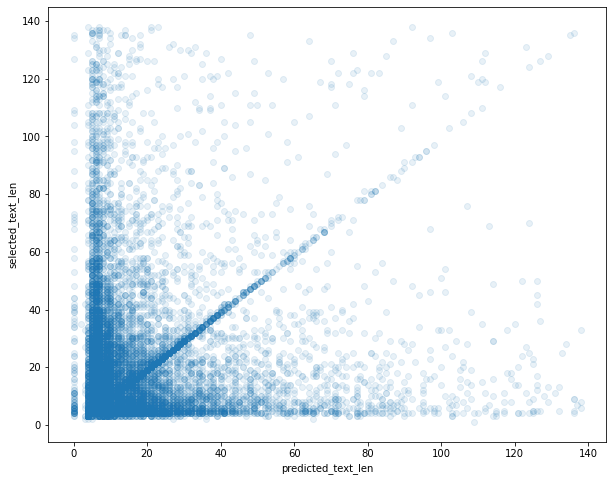

In [64]:
plt.figure(figsize=(10, 8))
plt.scatter(trn_df.query('sentiment != "neutral"')['predicted_texts_len'], trn_df.query('sentiment != "neutral"')['selected_text_len'], alpha=0.1)
plt.xlabel('predicted_text_len')
plt.ylabel('selected_text_len')
plt.show()

In [67]:
trn_df.query('predicted_texts_len == 0').shape

(98, 13)

In [69]:
trn_df.query('predicted_texts_len == text_len and sentiment != "neutral"').shape

(620, 13)

In [72]:
trn_df.query('selected_text_len == text_len and sentiment != "neutral"').shape

(1353, 13)

In [74]:
trn_df.query('selected_text_len == text_len and sentiment != "neutral"').head(100)

,textID,text,selected_text,sentiment,predicted_texts,manual_selected_text,selected_text_lower,manual_and_selected_intersection_len,manual_and_selected_tokenized_intersection_len,jaccard,text_len,selected_text_len,predicted_texts_len
15,8a939bfb59,"Uh oh, I am sunburned","Uh oh, I am sunburned",negative,sunburned,"uh oh, i am sunburned","uh oh, i am sunburned",5,8,0.200000,21,21,10
25,e00c6ef376,"the free fillin` app on my ipod is fun, im add...","the free fillin` app on my ipod is fun, im add...",positive,"fun,","the free fillin` app on my ipod is fun, im ad...","the free fillin` app on my ipod is fun, im ad...",11,15,0.090909,51,51,5
62,2a9765b7f9,I give in to easily,I give in to easily,negative,i give in to easily,i give in to easily,i give in to easily,5,5,1.000000,19,19,20
68,fa2654e730,Chilliin,Chilliin,positive,chilliin,chilliin,chilliin,1,3,1.000000,8,8,9
78,0a61cbf4b5,I am sooo tired,I am sooo tired,negative,i am sooo tired,i am sooo tired,i am sooo tired,4,5,1.000000,15,15,16
85,3d2fcd78c8,Happy Star Wars day everyone! and Enjoy the ho...,Happy Star Wars day everyone! and Enjoy the ho...,positive,happy,happy star wars day everyone! and enjoy the h...,happy star wars day everyone! and enjoy the h...,10,13,0.100000,56,56,6
95,4c41a35a2a,Happy Mothers day to all you Mums out there,Happy Mothers day to all you Mums out there,positive,happy,happy mothers day to all you mums out there,happy mothers day to all you mums out there,9,10,0.111111,43,43,6
124,f0460d611d,not well,not well,negative,not well,not well,not well,2,2,1.000000,8,8,9
144,7e4ed52c4a,Hate fighting,Hate fighting,negative,hate fighting,hate fighting,hate fighting,2,2,1.000000,13,13,14
146,48cdcd5f28,Car-warmed Sprite tastes like sore throat,Car-warmed Sprite tastes like sore throat,negative,sore throat,car-warmed sprite tastes like sore throat,car-warmed sprite tastes like sore throat,6,9,0.333333,41,41,12


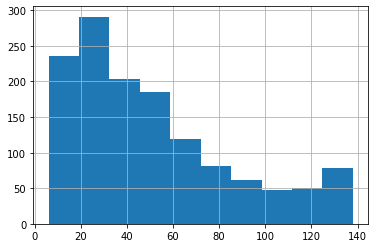

In [77]:
trn_df.query('selected_text_len == text_len and sentiment != "neutral"').selected_text_len.hist()

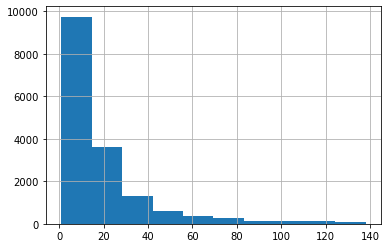

In [78]:
trn_df.query('sentiment != "neutral"').selected_text_len.hist()

In [56]:
trn_df.query('selected_text_len < 20 and jaccard < 0.2 and jaccard > 0').head(100)

,textID,text,selected_text,sentiment,predicted_texts,manual_selected_text,selected_text_lower,manual_and_selected_intersection_len,manual_and_selected_tokenized_intersection_len,jaccard,text_len,selected_text_len
27,bdc32ea43c,On the way to Malaysia...no internet access to...,.no internet,negative,no internet access to twit,...no internet,.no internet,1,2,0.166667,51,12
152,fd285fe74a,me too. I hate my computer so much..,hate,negative,i hate my computer so much..,hate,hate,1,1,0.166667,37,4
178,9d3a1e0269,really hopes her car`s illness is not terminal...,illness,negative,really hopes her car`s illness is not termina...,illness,illness,1,1,0.125000,49,7
213,4f84bea1cc,We never miss ICarly - my son has a huge crus...,crush,positive,we never miss icarly - my son has a huge crush,crush,crush,1,1,0.090909,58,5
245,7436ec1a2c,"yeah I was thinking about that ,ahaha",",ahaha",positive,"yeah i was thinking about that ,ahaha",",ahaha",",ahaha",1,3,0.142857,38,6
295,59e77db781,Watching Ellen Love her!! then doing the dishe...,.it`s gorgeous out!,positive,love her!! then doing the dishes and tanning ...,...it`s gorgeous out!,.it`s gorgeous out!,2,6,0.166667,82,19
452,2abfe0decb,lol. just don`t ever forget me,lol.,positive,lol. just don`t ever forget me,lol.,lol.,1,2,0.166667,31,4
480,9c2b1313af,Why kiss the feet of the people who kick you w...,best,positive,hope you have the best day ever,best,best,1,1,0.142857,138,4
581,21c1915272,http://twitpic.com/4v0vr - cool! you and your...,awesome,positive,cool! you and your mother have awesome hair s...,awesome,awesome,1,1,0.066667,111,7
631,ebeea1f86c,Am hating my life at the moment. There`s only ...,hating,negative,am hating my life at the moment.,hating,hating,1,1,0.142857,90,6


In [82]:
from torch.nn import BCELoss

In [83]:
loss = BCELoss()

In [90]:
loss(torch.tensor([0, 0, 1, 0, 1]).double(), torch.tensor([0, 0, 1, 0, 1]).double())

tensor(0., dtype=torch.float64)

In [91]:
import torch

In [93]:
torch.ones((10, 4)).cumsum(dim=1)

tensor([[1., 2., 3., 4.],
        [1., 2., 3., 4.],
        [1., 2., 3., 4.],
        [1., 2., 3., 4.],
        [1., 2., 3., 4.],
        [1., 2., 3., 4.],
        [1., 2., 3., 4.],
        [1., 2., 3., 4.],
        [1., 2., 3., 4.],
        [1., 2., 3., 4.]])

In [96]:
torch.ones((10, 4)).flip(dims=(1, )).cumsum(dim=1).flip(dims=(1, ))

tensor([[4., 3., 2., 1.],
        [4., 3., 2., 1.],
        [4., 3., 2., 1.],
        [4., 3., 2., 1.],
        [4., 3., 2., 1.],
        [4., 3., 2., 1.],
        [4., 3., 2., 1.],
        [4., 3., 2., 1.],
        [4., 3., 2., 1.],
        [4., 3., 2., 1.]])